In [84]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta






In [85]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [86]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [87]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [88]:



df = getQuotes(frameM30, 2019)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1546281000,1.14492,1.14593,1.14474,1.14543,1875,6,0
1,1546282800,1.14543,1.14564,1.14482,1.14482,1271,6,0
2,1546284600,1.14482,1.14512,1.14443,1.14512,1056,7,0
3,1546286400,1.14513,1.14545,1.14434,1.14451,1286,6,0
4,1546288200,1.14451,1.14467,1.14420,1.14450,940,6,0
...,...,...,...,...,...,...,...,...
58825,1695139200,1.06992,1.07009,1.06827,1.06891,4872,9,0
58826,1695141000,1.06891,1.06964,1.06868,1.06912,4852,9,0
58827,1695142800,1.06913,1.06930,1.06820,1.06856,3612,9,0
58828,1695144600,1.06856,1.06925,1.06846,1.06891,3690,9,0


In [89]:



def aroonOscillator(df, lookBackPeriod = 14):
    aroonOscillator = ta.aroon(high=df['high'], low=df['low'], length=lookBackPeriod)
    df[f'AROOND_{lookBackPeriod}'] = aroonOscillator[f'AROOND_{lookBackPeriod}']
    df[f'AROONU_{lookBackPeriod}'] = aroonOscillator[f'AROONU_{lookBackPeriod}']
    df[f'AROONOSC_{lookBackPeriod}'] = aroonOscillator[f'AROONOSC_{lookBackPeriod}']
    return df





In [90]:



lookBackPeriod = 500

df = aroonOscillator(df, lookBackPeriod)

df





,time,open,high,low,close,tick_volume,spread,real_volume,AROOND_500,AROONU_500,AROONOSC_500
0,1546281000,1.14492,1.14593,1.14474,1.14543,1875,6,0,NaN,NaN,NaN
1,1546282800,1.14543,1.14564,1.14482,1.14482,1271,6,0,NaN,NaN,NaN
2,1546284600,1.14482,1.14512,1.14443,1.14512,1056,7,0,NaN,NaN,NaN
3,1546286400,1.14513,1.14545,1.14434,1.14451,1286,6,0,NaN,NaN,NaN
4,1546288200,1.14451,1.14467,1.14420,1.14450,940,6,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
58825,1695139200,1.06992,1.07009,1.06827,1.06891,4872,9,0,73.0,0.6,-72.4
58826,1695141000,1.06891,1.06964,1.06868,1.06912,4852,9,0,72.8,0.4,-72.4
58827,1695142800,1.06913,1.06930,1.06820,1.06856,3612,9,0,72.6,0.2,-72.4
58828,1695144600,1.06856,1.06925,1.06846,1.06891,3690,9,0,72.4,0.0,-72.4


In [91]:






buysIndices = []
sellsIndices = []
buys = []
sells = []
position = None


### My Strategy
for i in range(len(df)):
    if (i > 0) and (not position) and (df.iloc[i][f'AROONOSC_{lookBackPeriod}'] <= -75):
        buysIndices.append(i)
        buys.append(df.iloc[i]['close'])
        position = 'long'
    elif (i > 0) and (position == 'long') and (df.iloc[i][f'AROONOSC_{lookBackPeriod}'] > 75):
        sellsIndices.append(i)
        sells.append(df.iloc[i]['close'])
        position = None

### Book Strategy

#for i in range(len(df)):
#    if (i > 0) and (not position) and (df.iloc[i][f'AROONU_{lookBackPeriod}'] > df.iloc[i][f'AROOND_{lookBackPeriod}']) and (df.iloc[i - 1][f'AROONU_{lookBackPeriod}'] < df.iloc[i - 1][f'AROOND_{lookBackPeriod}']):
#        buysIndices.append(i)
#        buys.append(df.iloc[i]['close'])
#        position = 'long'
#    elif (i > 0) and (position == 'long') and (df.iloc[i][f'AROOND_{lookBackPeriod}'] > df.iloc[i][f'AROONU_{lookBackPeriod}']) and (df.iloc[i - 1][f'AROOND_{lookBackPeriod}'] < df.iloc[i - 1][f'AROONU_{lookBackPeriod}']):
#        sellsIndices.append(i)
#        sells.append(df.iloc[i]['close'])
#        position = None











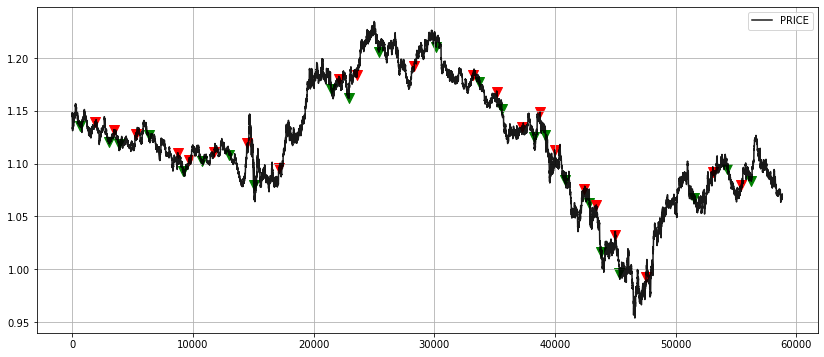

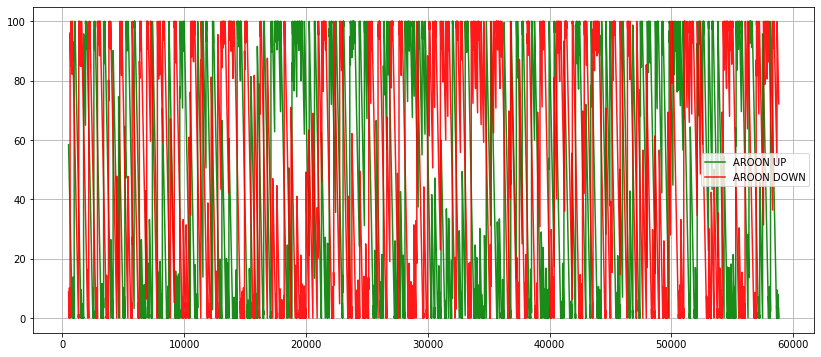

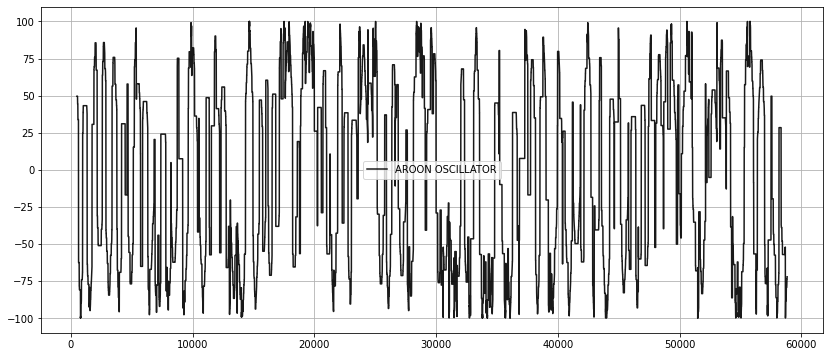

In [92]:









plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='PRICE', color='black', alpha=0.9)
plt.scatter(df.iloc[buysIndices].index, df.iloc[buysIndices]['close'], marker = 'v', color = 'g', s = 100)
plt.scatter(df.iloc[sellsIndices].index, df.iloc[sellsIndices]['close'], marker = 'v', color = 'r', s = 100)
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(14, 6))
plt.plot(df[f'AROONU_{lookBackPeriod}'], label='AROON UP', color='green', alpha=0.9)
plt.plot(df[f'AROOND_{lookBackPeriod}'], label='AROON DOWN', color='red', alpha=0.9)
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(df[f'AROONOSC_{lookBackPeriod}'], label='AROON OSCILLATOR', color='black', alpha=0.9)
plt.legend()
plt.grid(True)
plt.show()









In [93]:







totalPL = 0
lostTrades = 0
winTrades = 0

for i in range(len(sells)):
    netResult = sells[i] - buys[i]
    m = max(sells[i], buys[i])
    b = 2 / 100 * m
    netResult = netResult - b
    totalPL = totalPL + netResult
    if netResult > 0:
        winTrades = winTrades + 1
    else:
        lostTrades = lostTrades + 1
    print(f'Net Trade Result = {netResult}')

print(f'Total P & L is, {totalPL}')
print(f'Win Trades, {winTrades}, winPercentage = {(winTrades / len(sells)) * 100}')
print(f'Lost Trades, {lostTrades}, lostPercentage = {(lostTrades / len(sells) * 100)}')





Net Trade Result = -0.018266800000000076
Net Trade Result = -0.011804800000000105
Net Trade Result = -0.013537599999999973
Net Trade Result = -0.038954200000000105
Net Trade Result = -0.011599600000000022
Net Trade Result = -0.013497199999999938
Net Trade Result = -0.01148660000000009
Net Trade Result = -0.006380799999999957
Net Trade Result = -0.013685199999999852
Net Trade Result = -0.0013337999999999094
Net Trade Result = -0.0378834
Net Trade Result = -0.05057359999999994
Net Trade Result = -0.03300020000000003
Net Trade Result = -0.03998680000000002
Net Trade Result = 0.00040240000000017415
Net Trade Result = -0.03707180000000009
Net Trade Result = -0.02958200000000002
Net Trade Result = -0.02318699999999999
Net Trade Result = -0.004227800000000118
Net Trade Result = -0.024138399999999983
Net Trade Result = 0.003440600000000033
Net Trade Result = -0.03714199999999999
Total P & L is, -0.4534966
Win Trades, 2, winPercentage = 9.090909090909092
Lost Trades, 20, lostPercentage = 90.909